# Determining Car Prices

A service for selling used cars with the tagline "Not crashed, not painted" is developing an application to attract new customers. In this app, users can quickly find out the market value of their cars. Historical data is available, including technical specifications, configurations, and prices of cars. The primary goal of this project is to build a machine learning model that can accurately predict the prices of used cars. This model will be integrated into a mobile application to provide users with quick and reliable estimates of their car's market value.

The client has specified several criteria for choosing the model:

 - Prediction quality
 - Prediction speed
 - Training time
 
We have historical data at our disposal, which includes technical specifications, configurations, and prices of cars.

**Data Description**

**Features**:

 - DateCrawled: The date when the car listing was crawled from the database.
 - VehicleType: The type of car body.
 - RegistrationYear: The year of car registration.
 - Gearbox: The type of gearbox (manual or automatic).
 - Power: Engine power in horsepower.
 - Model: Car model.
 - Kilometer: Mileage in kilometers.
 - RegistrationMonth: The month of car registration.
 - FuelType: Fuel type.
 - Brand: Car brand.
 - Repaired: Whether the car has been repaired or not.
 - DateCreated: The date when the listing was created.
 - NumberOfPictures: The number of car photos.
 - PostalCode: The postal code of the listing owner (user).
 - LastSeen: The date of the user's last activity.

Target is the price of a car in euros.

## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, Pool

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, 
                                     train_test_split,
                                     cross_val_score,
                                     KFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   StandardScaler
)                                   
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [2]:
data = pd.read_csv('/Users/mojseenkodenis/Desktop/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


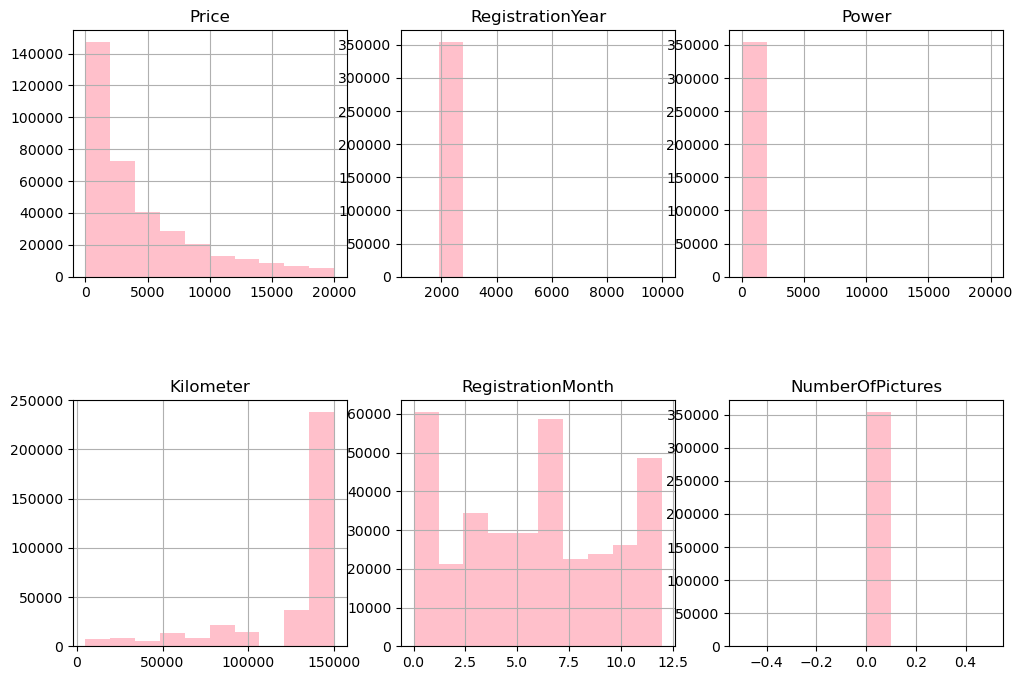

In [6]:
#Taking a look at the distribution of data in columns with numerical data
quantitative_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(quantitative_columns):
    row = i // 3
    col = i % 3
    
    data[column].hist(ax=axes[row, col], color='pink')
    axes[row, col].set_title(f'{column}')
    
plt.show()

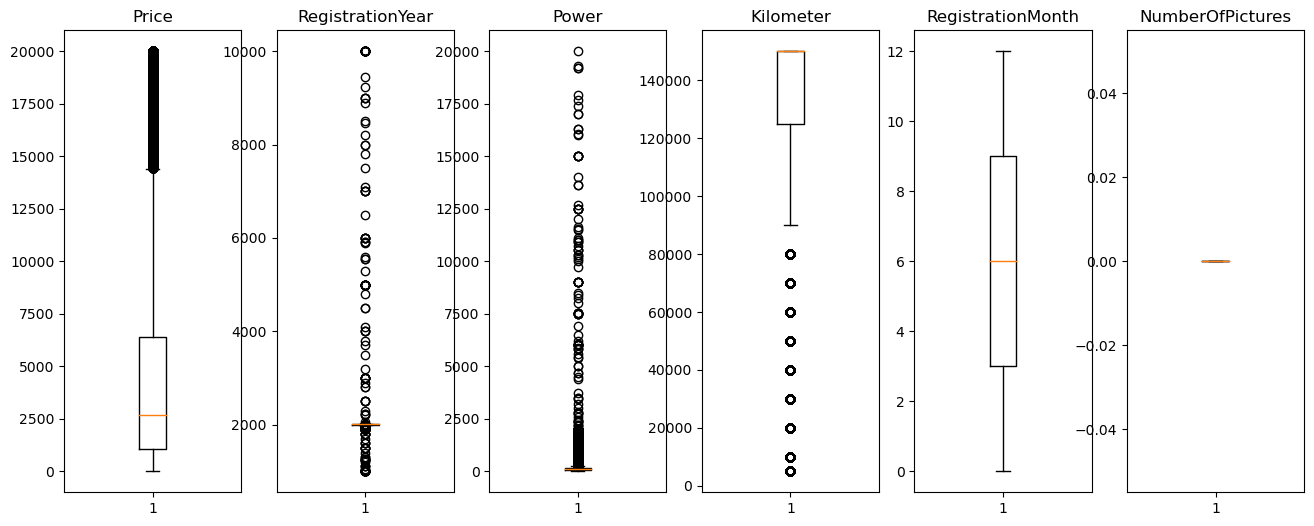

In [7]:
#Now let's look for outliers using box plots on numerical data 
quantitative_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']

fig, axes = plt.subplots(nrows=1, ncols=len(quantitative_columns), figsize=(16, 6))

for i, col in enumerate(quantitative_columns):
    axes[i].boxplot(data[col])
    axes[i].set_title(col)

plt.show()

After analyzing the data, it can be noted that the numerical features are not normally distributed, and there are a significant number of outliers in the columns Price, RegistrationYear, and Power. Additionally, in the NumberOfPictures column, all values are empty.

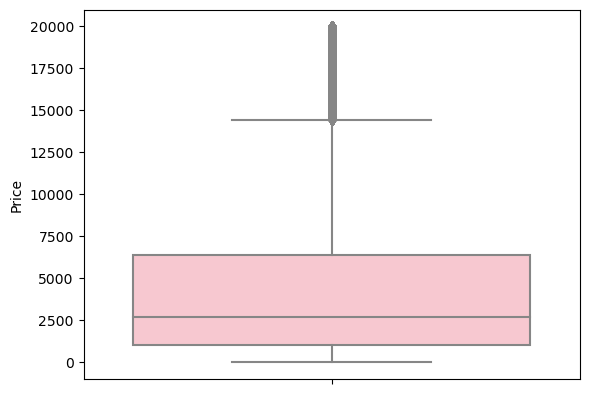

In [8]:
#Examining the distribution of the Price feature separately
sns.boxplot(y=data['Price'], color='pink');

In [9]:
#Let's look at the rows with zero prices
data.query('Price == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


In [10]:
#Deleting the rows with zero prices
data = data[data['Price'] > 0]

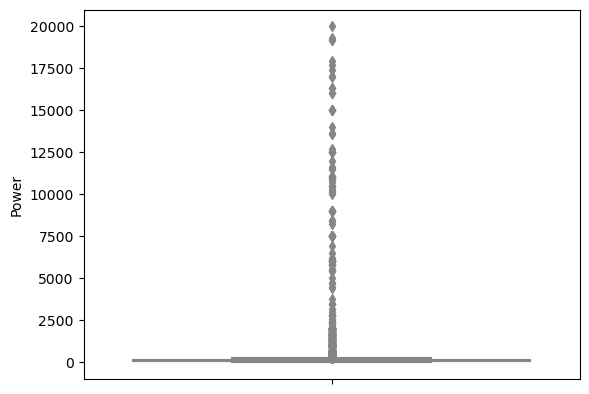

In [11]:
#Looking at the distribution of the Power feature
sns.boxplot(y=data['Power'], color='pink');

In [12]:
data['Power'].value_counts()

0       36360
75      23319
60      15465
150     14170
101     12960
        ...  
519         1
2461        1
6006        1
5815        1
1241        1
Name: Power, Length: 701, dtype: int64

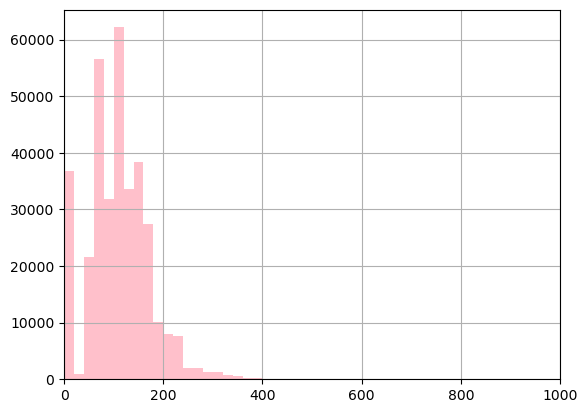

In [13]:
data['Power'].hist(color='pink', bins=1000);
plt.xlim([0, 1000])
plt.show()

In the Power column, there are outliers as well, but they do not significantly affect the overall distribution, so I will not remove them. However, there are 36,360 zero values in the column which will be removed.

In [14]:
data = data[data['Power'] > 0]

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']


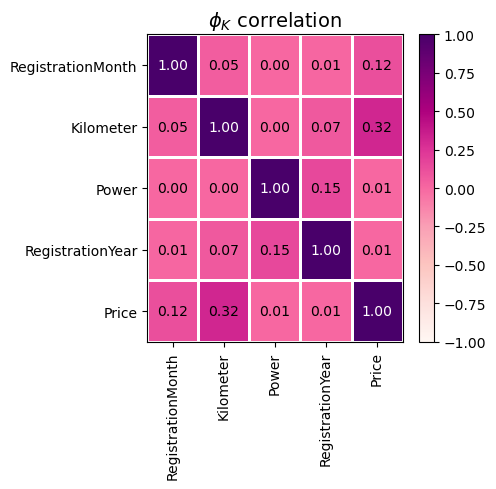

In [15]:
#Looking at the correlation between the columns
phik_correlation = data.loc[:, quantitative_columns].phik_matrix()
plot_correlation_matrix(phik_correlation.values,
                        x_labels=phik_correlation.columns,
                        y_labels=phik_correlation.index,
                        title='$\phi_K$ correlation',
                        figsize=(5, 5),
                        color_map='RdPu')

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']


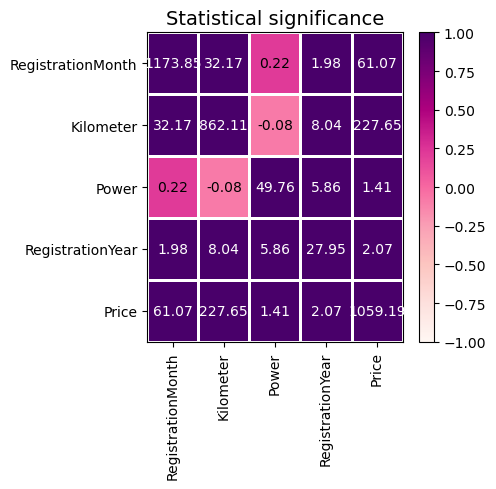

In [16]:
#Looking at the statistical significance of the features
significance = data.loc[:, quantitative_columns].significance_matrix()
plot_correlation_matrix(significance.values, 
                        x_labels=significance.columns, 
                        y_labels=significance.index, 
                        title='Statistical significance', 
                        figsize=(5, 5),
                        color_map='RdPu')

After the correlation analysis, it can be seen that the most features are independent of each other, excapt for Price and Kilometer, which have small level of correlation (0.32). Also, all features are statistically significant. Even Power, which got lower level of significance with RegistrationMonth and Kilometer, is significant with other features. Therefore, no numerical columns will be deleted as they all present important information for model learning.

In [17]:
data['NumberOfPictures'].value_counts()

0    307237
Name: NumberOfPictures, dtype: int64

In the NumberOfPictures column, all values are empty, meaning they have no significance for the model. Therefore, we will remove them from the final dataset.

In [18]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled']).dt.round('D')
data['DateCreated'] = pd.to_datetime(data['DateCreated']).dt.round('D')

In [19]:
difference = (data['DateCrawled'] - data['DateCreated'])
difference.value_counts().head(10)

1 days     240985
0 days      63987
2 days        958
3 days        432
7 days         76
4 days         75
5 days         72
6 days         64
8 days         57
16 days        39
dtype: int64

The majority of the data was crawled one day after the sale, so in the final dataset, there is no need to keep both the DateCrawled and DateCreated columns. Therefore, we will remove DateCrawled.

In [20]:
#Removing uninformative columns
data = data.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [21]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04


Now let's deal with duplicates and missing values.

In [22]:
data.duplicated().sum()

11809

In [23]:
#Removing duplicates
data = data.drop_duplicates()

In [24]:
data.isna().sum()

Price                   0
VehicleType         21043
RegistrationYear        0
Gearbox              5980
Power                   0
Model               12293
Kilometer               0
FuelType            19554
Brand                   0
Repaired            46234
DateCreated             0
dtype: int64

In [25]:
data['FuelType'].value_counts()

petrol      184805
gasoline     85615
lpg           4594
cng            491
hybrid         199
other           94
electric        76
Name: FuelType, dtype: int64

In [26]:
#Petrol and Gasoline are essentially the same type of fuel, with "Petrol" being the term used in Europe and "Gasoline" in the USA
#Therefore, we will replace "Gasoline" with "Petrol" to make the terminology consistent.
data['FuelType'] = data['FuelType'].replace(['gasoline'],'petrol')

In [27]:
#Replacing the missing values with the category "Other"
data['FuelType'].fillna('other', inplace=True)

In [28]:
data['VehicleType'].value_counts()

sedan          79680
small          67330
wagon          56857
bus            25329
convertible    18070
coupe          14134
suv            10519
other           2466
Name: VehicleType, dtype: int64

In [29]:
#It's impossible to determine the vehicle type from the provided data, so we will replace the missing values with "other"
data['VehicleType'].fillna('other', inplace=True)

In [30]:
data['Gearbox'].value_counts()

manual    231404
auto       58044
Name: Gearbox, dtype: int64

In [31]:
data['Model'].value_counts().head(10)

golf        24888
other       20212
3er         17016
polo        10693
corsa       10046
astra        9098
passat       8564
a4           8546
c_klasse     7117
5er          6907
Name: Model, dtype: int64

In [32]:
#Replacing the missing values in the "Gearbox" and "Model" columns with "unknown"
data['Gearbox'].fillna('unknown', inplace=True)
data['Model'].fillna('unknown', inplace=True)

In [33]:
#In the "Repaired" column, we will assume that if the user did not specify, the car was most likely not repaired
#Thus, replacing the missing values with "no"
data['Repaired'].fillna('no', inplace=True)

In [34]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,2016-03-31
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04


In [35]:
#Extracting the data for days of the week, months, and years from the "DateCreated" column
data["weekday"] = data["DateCreated"].dt.weekday
data["month"] = data["DateCreated"].dt.month
data["year"] = data["DateCreated"].dt.year

data = data.drop('DateCreated', axis=1)

In [36]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,weekday,month,year
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes,3,3,2016
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no,0,3,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,3,3,2016
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,3,3,2016
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0,4,2016


In [37]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
weekday             0
month               0
year                0
dtype: int64

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295428 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295428 non-null  int64 
 1   VehicleType       295428 non-null  object
 2   RegistrationYear  295428 non-null  int64 
 3   Gearbox           295428 non-null  object
 4   Power             295428 non-null  int64 
 5   Model             295428 non-null  object
 6   Kilometer         295428 non-null  int64 
 7   FuelType          295428 non-null  object
 8   Brand             295428 non-null  object
 9   Repaired          295428 non-null  object
 10  weekday           295428 non-null  int64 
 11  month             295428 non-null  int64 
 12  year              295428 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 31.6+ MB


The initial dataset contained both irrelevant features for training subsequent models and features with outliers, missing values, and duplicates.

As a result:

 - Non-informative features DateCrawled, RegistrationYear, RegistrationMonth, NumberOfPictures, PostalCode, and LastSeen were removed.

Additionally:

 - Zero values in Price and Power were removed
 - Two categories with the same name in FuelType were merged, and missing values were included in the "other" category, similar to VehicleType
 - Missing values in Gearbox and Model were replaced with "unknown"
 - In the end, columns for days of the week, months, and years were created from DateCreated

## Model training

In [39]:
#Encoding the data using one-hot encoding
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,weekday,month,year,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
1,18300,2011,190,125000,3,3,2016,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,3,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,3,3,2016,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,3,3,2016,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
numeric = ['Power', 'Kilometer', 'weekday', 'month', 'year']

In [41]:
#Splitting the dataset into training, validation, and test sets with a 60%-20%-20% ratio
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)

features_train_ohe, features_valid_test_ohe, target_train_ohe, target_valid_test_ohe = train_test_split(features_ohe, 
                                                                                        target_ohe, 
                                                                                        test_size=0.4, 
                                                                                        random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_valid_test_ohe,
                                                                            target_valid_test_ohe,
                                                                            test_size=0.5, random_state=12345)

print('Training set: ', features_train_ohe.shape[0] / features_ohe.shape[0] * 100)
print('Validation set: ', features_valid_ohe.shape[0] / features_ohe.shape[0] * 100)
print('Test set: ', features_test_ohe.shape[0] / features_ohe.shape[0] * 100)

Training set:  59.99972920643947
Validation set:  20.000135396780262
Test set:  20.000135396780262


In [42]:
#Scaling features
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [43]:
features_train_ohe.head()

,RegistrationYear,Power,Kilometer,weekday,month,year,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
259272,1999,0.352584,0.589200,0.051328,-0.425491,0.008888,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236422,2009,-0.272081,-0.766399,0.051328,-0.425491,0.008888,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
198837,2002,-0.328403,0.589200,1.012874,2.221132,0.008888,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88227,2014,-0.256720,-3.206478,0.532101,-0.425491,0.008888,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289790,2007,0.234819,0.589200,-1.390992,2.221132,0.008888,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Linear Regression

In [44]:
parameters_linear = {
    'positive': [True, False], 
    'fit_intercept': [True, False]
}

model_linear = LinearRegression()

gs_linear = GridSearchCV(model_linear, parameters_linear, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gs_linear.fit(features_train_ohe, target_train_ohe)
pred_linear = gs_linear.best_estimator_.predict(features_valid_ohe)

rmse_linear = np.sqrt(mean_squared_error(target_valid_ohe, pred_linear))

print(f'RMSE for Linear Regression is: {rmse_linear}')
print(f'The best parameters: {gs_linear.best_params_}')

RMSE for Linear Regression is: 3226.30712539266
The best parameters: {'fit_intercept': False, 'positive': False}


### Random Forest

In [45]:
#Splitting the dataset into training, validation, and test sets
target = data['Price']
features = data.drop('Price', axis=1)

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        test_size=0.4, 
                                                                                        random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.5, random_state=12345)

print('Training set: ', features_train.shape[0] / features.shape[0] * 100)
print('Validation set: ', features_valid.shape[0] / features.shape[0] * 100)
print('Test set: ', features_test.shape[0] / features.shape[0] * 100)

Training set:  59.99972920643947
Validation set:  20.000135396780262
Test set:  20.000135396780262


In [46]:
#Encoding the features of the datasets using ordinal encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train)
features_train_ord = encoder.transform(features_train)
features_valid_ord = encoder.transform(features_valid)
features_test_ord = encoder.transform(features_test)

In [47]:
pipeline_forest = Pipeline(
    [('dforest', RandomForestRegressor(random_state=RANDOM_STATE))])

parameters_forest = {
    'dforest__max_depth': range(1, 10),
    'dforest__min_samples_split': (2, 3),
}

gs_forest = GridSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gs_forest.fit(features_train_ord, target_train)
pred_forest = gs_forest.best_estimator_.predict(features_valid_ord)

rmse_forest = np.sqrt(mean_squared_error(target_valid, pred_forest))

print(f'RMSE for Random Forest is: {rmse_forest}')
print(f'The best parameters: {gs_forest.best_params_}')

RMSE for Random Forest is: 1978.153188998175
The best parameters: {'dforest__max_depth': 9, 'dforest__min_samples_split': 2}


### Decision Tree

In [48]:
pipeline_tree = Pipeline(
    [('dtree', DecisionTreeRegressor(random_state=RANDOM_STATE))])

parameters_tree = {
    'dtree__min_samples_split': [2, 3, 4],
    'dtree__min_samples_leaf': [1, 4, 8]
}

gs_tree = GridSearchCV(pipeline_tree, parameters_tree, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gs_tree.fit(features_train_ord, target_train)
pred_tree = gs_tree.best_estimator_.predict(features_valid_ord)

rmse_tree = np.sqrt(mean_squared_error(target_valid, pred_tree))

print(f'RMSE for Decision Tree is: {rmse_tree}')
print(f'The best parameters: {gs_tree.best_params_}')

RMSE for Decision Tree is: 1855.097512330078
The best parameters: {'dtree__min_samples_leaf': 8, 'dtree__min_samples_split': 2}


### CatBoost

In [49]:
pipeline_catboost = Pipeline(
    [('dcat', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])

parameters_catboost = { 
    'dcat__learning_rate': [0.01, 0.05, 0.1, 0.2],   
    'dcat__l2_leaf_reg': [1, 3, 5, 7] 
}

gs_catboost = GridSearchCV(pipeline_catboost, parameters_catboost, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
gs_catboost.fit(features_train_ord, target_train)
pred_catboost = gs_catboost.best_estimator_.predict(features_valid_ord)

rmse_catboost = np.sqrt(mean_squared_error(target_valid, pred_catboost))

print(f'RMSE for CatBoost is: {rmse_catboost}')
print(f'The best parameters: {gs_catboost.best_params_}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
RMSE for CatBoost is: 1644.1255975574477
The best parameters: {'dcat__l2_leaf_reg': 1, 'dcat__learning_rate': 0.2}


In [50]:
results = pd.DataFrame(
    [rmse_linear, 
     rmse_tree,
     rmse_forest,
     rmse_catboost], 
    index=['Linear regression', 'Decision tree', 'Random Forest', 'CatBoost Regressor'], 
    columns=['RMSE']
)
results.sort_values(by='RMSE')

,RMSE
CatBoost Regressor,1644.125598
Decision tree,1855.097512
Random Forest,1978.153189
Linear regression,3226.307125


At the second stage, four models were trained: linear regression, random forest, decision tree, and CatBoost.

For linear regression, the data was encoded using one-hot encoding, while ordinal encoding was used for random forest and decision tree.

As a result, the best RMSE score was achieved with CatBoost, which had an RMSE of 1644.12.

## Model analysis

### Linear Regression

In [51]:
%time
lin_model = LinearRegression(fit_intercept=False, positive=False)
lin_model.fit(features_train_ohe, target_train_ohe)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


LinearRegression(fit_intercept=False)

In [52]:
%time
lin_pred = lin_model.predict(features_train_ohe)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 9.06 µs


### Random Forest

In [53]:
%time
model_forest = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=9, min_samples_split=2)
model_forest.fit(features_train_ord, target_train)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.2 µs


RandomForestRegressor(max_depth=9, random_state=12345)

In [54]:
%time
forest_pred = model_forest.predict(features_train_ord)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


### Decision Tree

In [55]:
%time
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE, min_samples_leaf=8, min_samples_split=2)
model_tree.fit(features_train_ord, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


DecisionTreeRegressor(min_samples_leaf=8, random_state=12345)

In [56]:
%time
tree_pred = model_tree.predict(features_train_ord)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


### CatBoost

In [57]:
%%time
model_cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, l2_leaf_reg=1, learning_rate=0.2)
model_cat.fit(features_train_ord, target_train)

CPU times: user 51.4 s, sys: 2.61 s, total: 54 s
Wall time: 19.5 s


In [58]:
%time
predictions_cat = model_cat.predict(features_train_ord)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


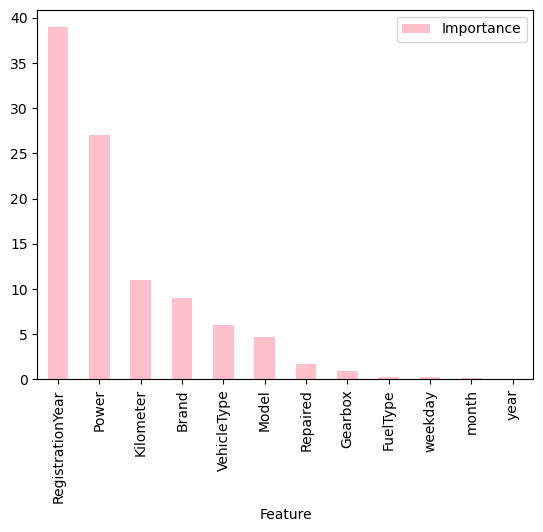

In [59]:
feature_importances = model_cat.get_feature_importance()
feature_names = features_train.columns  

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).set_index('Feature')
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.plot(kind='bar', color='pink');

In [62]:
results = [['Linear Regression: training', '4 µs', '5.96 µs'],
             ['Linear Regression: prediction', '7 µs', '9.06 µs'],
             ['Random Forest: training', '7 µs', '12.2 µs'],
         ['Random Forest: prediction', '6 µs', '10 µs'],
         ['Decision Tree: training', '3 µs', '5.72 µs'],
         ['Decision Tree: prediction', '3 µs', '5.72 µs'],
         ['CatBoost: training', '54 s', '19.5 s'],
         ['CatBoost: prediction', '4 µs', '6.2 µs']]
df = pd.DataFrame(results, columns=['Model','CPU-times', 'Wall time'])
df = df.set_index('Model')
df.index.names = [None]
df

,CPU-times,Wall time
Linear Regression: training,4 µs,5.96 µs
Linear Regression: prediction,7 µs,9.06 µs
Random Forest: training,7 µs,12.2 µs
Random Forest: prediction,6 µs,10 µs
Decision Tree: training,3 µs,5.72 µs
Decision Tree: prediction,3 µs,5.72 µs
CatBoost: training,54 s,19.5 s
CatBoost: prediction,4 µs,6.2 µs


Based on the speed of training and prediction, it can be noted that Decision Tree trains the fastest, while CatBoost is the fastest for making predictions. Additionally, an analysis of feature importance for the CatBoost model revealed that the "RegistrationYear" and "Power" features play a significant role. Features created based on the sales data did not have a substantial impact on the training, so they could be removed in further model refinement.

In conclusion, for testing on the test dataset, we will choose the CatBoost model as it performed the best in terms of accuracy with an RMSE of 1644. However, it's important to note that CatBoost takes longer to train. If speed is more important than accuracy for the company, the Decision Tree model, which trained the fastest among the models, could be considered.

### Testing the model

In [61]:
final_cat_pred = model_cat.predict(features_test_ord)
print('RMSE on the test set:', mean_squared_error(target_test, final_cat_pred)**0.5)

RMSE on the test set: 1629.1018039398743


In the end, the model achieved an RMSE of 1629 on the test dataset, which is slightly lower than the result on the training dataset. Therefore, it suggests that the model is not suffering from underfitting or overfitting.

## Conclusion

Initially dataset with 354,000 rows and 16 columns was offered for training. The goal was to build a machine learning model that can accurately predict the prices of used cars. The model will be integrated into a mobile application to provide users with quick and reliable estimates of their car's market value.

During data preprocessing, uninformative features, outliers and duplicates and missing values were removed, resulting in 295,000 rows and 13 columns.

Four models were trained: linear regression, random forest, decision tree, and CatBoost. CatBoost achieved the best accuracy on the training dataset, although it took more time to train. In terms of accuracy, CatBoost is recommended for integration into the application.